In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
import numpy as np
import os

num_train = 2000              # 訓練データの画像数
num_validation = 800          # テストデータの画像数
img_h, img_w = 150, 150       # 画像のサイズ
channels = 3                  # チャンネル数
batch_size = 32               # ミニバッチのサイズ
train_data_dir = 'data/train' # 訓練データのフォルダー
validation_data_dir = 'data/validation' # テストデータのフォルダー
result_dir = 'results'        # VGG16の出力結果を保存するフォルダー

# resultsフォルダーが存在しなければ作成
if not os.path.exists(result_dir):
    os.mkdir(result_dir)

def save_VGG16_outputs():
    '''
    VGG16にDog vs Catの訓練データ、テストデータを入力し、
    出力結果をnpyファイルに保存する
    
　　'''  
    # VGG16モデルと学習済み重みを読み込む
    model = VGG16(
        include_top=False,            # 全結合層は層（FC）は読み込まない
        weights='imagenet',           # ImageNetで学習した重みを利用
        input_shape=(img_h, img_w, channels) # 入力データの形状
    )
    # サマリを表示
    model.summary()

    # テストデータを読み込むジェネレーターを生成
    datagen = ImageDataGenerator(rescale=1.0 / 255)
    # Dog vs Catの訓練データを生成するするジェネレーター
    train_generator = datagen.flow_from_directory(
        train_data_dir,               # 訓練データのフォルダー
        target_size=(img_w, img_h),   # 画像をリサイズ
        batch_size=batch_size,        # ミニバッチのサイズ
        class_mode=None,              # 出力層は存在しないのでclass_modeはNone
        shuffle=False)                # データをシャッフルしない
    # テストデータの正解ラベルを出力
    print('train-label:',train_generator.class_indices) 
    # 訓練データをVGG16モデルに入力し、その出力をファイルに保存
    vgg16_train = model.predict_generator(
        train_generator,              # ジェネレーター
        verbose=1                     # 進捗状況を出力
    )
    # 訓練データの出力を保存
    np.save(os.path.join(result_dir, 'vgg16_train.npy'),
            vgg16_train)

    # Dog vs Catのテストデータを生成するジェネレーター
    validation_generator = datagen.flow_from_directory(
        validation_data_dir,          # 訓練データのフォルダー
        target_size=(img_w, img_h),   # 画像をリサイズ
        batch_size=batch_size,        # ミニバッチのサイズ
        class_mode=None,              # 出力層は存在しないのでclass_modeはNone
        shuffle=False)                # データをシャッフルしない
    # テストデータの正解ラベルを出力
    print('test-label:',validation_generator.class_indices)
    # テストデーターをVGG16モデルに入力する
    vgg16_test = model.predict_generator(
        validation_generator,         # ジェネレーター
        verbose=1                     # 進捗状況を出力
    )
    # テストデータの出力を保存
    np.save(os.path.join(result_dir, 'vgg16_test.npy'),
            vgg16_test)

Using TensorFlow backend.


In [2]:
# VGG16に入力して結果を保存
save_VGG16_outputs()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
import os
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation, Dropout, Flatten, Dense

def train_FClayer():
    '''
    VGG16の出力を入力し、FCネットワークで学習する
    
    '''
    # 訓練データのVGG16からの出力を読み込む
    train_data = np.load(
        os.path.join(result_dir, 'vgg16_train.npy'))    
    # VGG16の訓練データの形状を出力
    print(train_data.shape)    
    # 正解ラベルの作成 最初の2000枚が0(cat),次の2000枚が1(dag)
    train_labels = np.array(
        [0] * int(num_train / 2) + [1] * int(num_train / 2)
    )

    # テストデータのVGG16からの出力を読み込む
    validation_data = np.load(
        os.path.join(result_dir, 'vgg16_test.npy'))
    # VGG16のテストデータの形状を出力
    print(validation_data.shape)    
    # 正解ラベルを作成
    # ネコが0、イヌが1
    # 最初の800枚(cat)に0、次の800枚(dog)に1を割り当てる
    validation_labels = np.array(
        [0] * int(num_validation / 2) + [1] * int(num_validation / 2)
    )

    # FCネットワークの作成
    model = Sequential()
    # Flatten　全結合層への入力を4階テンソルから2階テンソルに変換する
    model.add(Flatten(input_shape=train_data.shape[1:]))
    # 全結合層
    model.add(Dense(256,                   # ニューロン数は256
                    activation='relu'))    # 活性化関数はReLU
    model.add(Dropout(0.5))                # ドロップアウト50％
    # 出力層
    model.add(Dense(1,                     # ニューロン数は256
                    activation='sigmoid')) # 活性化関数はReLU

    # モデルのコンパイル
    model.compile(
        loss='binary_crossentropy',        # バイナリ用の交差エントロピー誤差
        metrics=['accuracy'],              # 学習評価として正解率を指定
        # 確率的勾配降下法で最適化 学習率0.0001
        # 慣性項(Momentum)を0.9にして前回の更新量に0.9倍して加算することで
        # パラメータの更新を慣性的なものにする
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    )

    # 学習の実行
    epoch = 60                             # 学習回数
    batch_size = 32                        # ミニバッチのサイズ
    history = model.fit(train_data,        # 訓練データ
                        train_labels,      # 訓練データの正解ラベル
                        epochs=epoch,      # 学習回数
                        batch_size=batch_size,
                        verbose=1,
                        # テストデータと正解ラベル
                        validation_data=(validation_data,
                                         validation_labels)
                        )
    
    # 学習結果の保存
    with open('model.json', 'w') as json_file:
        json_file.write(model.to_json())
    model.save_weights('weight.h5')

    # historyを返す
    return history

In [6]:
# VGG16の出力をFCネットワークで学習
history = train_FClayer()

(2000, 4, 4, 512)
(800, 4, 4, 512)
Train on 2000 samples, validate on 800 samples
Epoch 1/60
2000/2000 [==============================] - 2s 861us/step - loss: 0.7275 - acc: 0.5540 - val_loss: 0.6020 - val_acc: 0.7225
Epoch 2/60
2000/2000 [==============================] - 1s 724us/step - loss: 0.5982 - acc: 0.6740 - val_loss: 0.5355 - val_acc: 0.7837
Epoch 3/60
2000/2000 [==============================] - 1s 701us/step - loss: 0.5276 - acc: 0.7595 - val_loss: 0.4934 - val_acc: 0.8187
Epoch 4/60
2000/2000 [==============================] - 1s 678us/step - loss: 0.5060 - acc: 0.7620 - val_loss: 0.4693 - val_acc: 0.8163
Epoch 5/60
2000/2000 [==============================] - 1s 678us/step - loss: 0.4749 - acc: 0.7870 - val_loss: 0.4437 - val_acc: 0.8337
Epoch 6/60
2000/2000 [==============================] - 1s 695us/step - loss: 0.4497 - acc: 0.8110 - val_loss: 0.4245 - val_acc: 0.8350
Epoch 7/60
2000/2000 [==============================] - 1s 660us/step - loss: 0.4399 - acc: 0.7985 - v

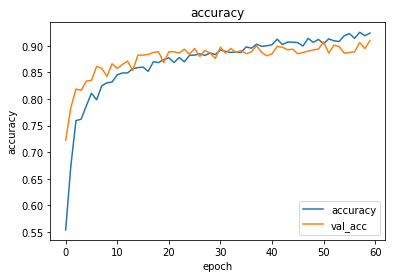

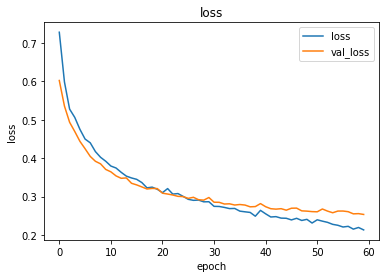

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_acc_loss(history):
    # 精度の推移をプロット
    plt.plot(history.history['acc'],"-",label="accuracy")
    plt.plot(history.history['val_acc'],"-",label="val_acc")
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の推移をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()
    
# 損失と精度をグラフに出力
plot_acc_loss(history)